# Amazon project - Employee Access Challenge

| Column name | Description |
| --- | --- |
| ACTION | 1, если ресурс был утвержден, 0, если ресурс не был |
| RESOURCE | Идентификатор ресурса |
| MGR_ID | Идентификатор руководителя данного работника - у работника может быть только один руководитель |
| ROLE_ROLLUP_1 | Идентификатор категории группы профессий/ролей компании 1 (US Engineering)  |
| ROLE_ROLLUP_2 | Идентификатор категории группы профессий/ролей компании 2 (US Retail) |
| ROLE_DEPTNAME | Название отдела (Retail) |
| ROLE_TITLE | Название роли в этой компании (Senior Engineering Retail Manager) |
| ROLE_FAMILY_DESC | Расширенное описание профессии (Retail Manager, Software Engineering) |
| ROLE_FAMILY | Описание роли/профессии, название (Retail Manager) |
| ROLE_CODE | Код компании; этот код уникален для каждой роли |

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [39]:
train = pd.read_csv("C:/Users/Lenovo/Downloads/data/train.csv")
test = pd.read_csv("C:/Users/Lenovo/Downloads/data/test.csv")

y = train["ACTION"]

In [40]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
id                  58921 non-null int64
RESOURCE            58921 non-null int64
MGR_ID              58921 non-null int64
ROLE_ROLLUP_1       58921 non-null int64
ROLE_ROLLUP_2       58921 non-null int64
ROLE_DEPTNAME       58921 non-null int64
ROLE_TITLE          58921 non-null int64
ROLE_FAMILY_DESC    58921 non-null int64
ROLE_

In [41]:
# Чтобы узнать разброс значений, среднюю стоимость и медиану в каждом из признаков, используем метод .describe():
train.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


In [42]:
# Проверим, имеются ли пустые, незаполненные ячейки в тренировочной выборке
train.isna().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [43]:
# Наблюдаем баланс выборки и как распределены данные в тренировочной выборке по искомому критерию
train.groupby('ACTION').count()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
ACTION,,,,,,,,,
0,1897,1897,1897,1897,1897,1897,1897,1897,1897
1,30872,30872,30872,30872,30872,30872,30872,30872,30872


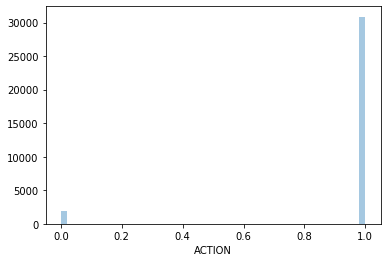

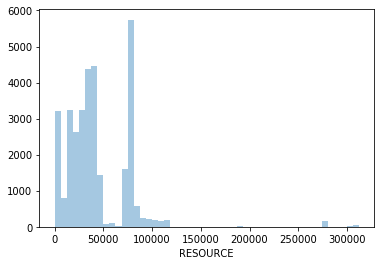

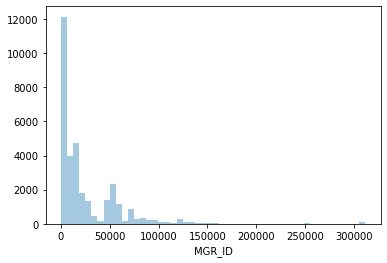

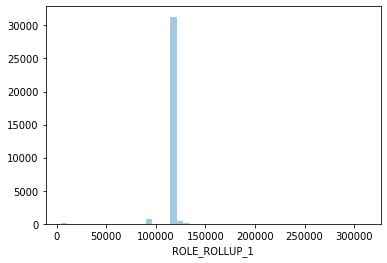

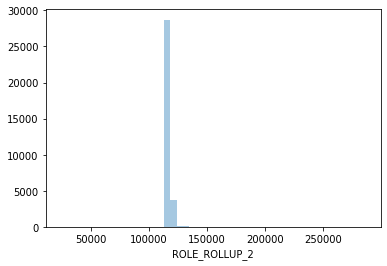

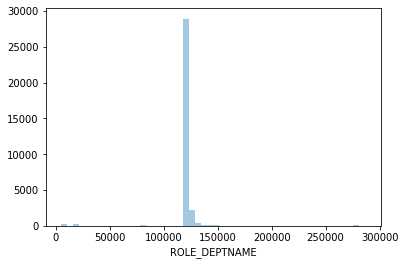

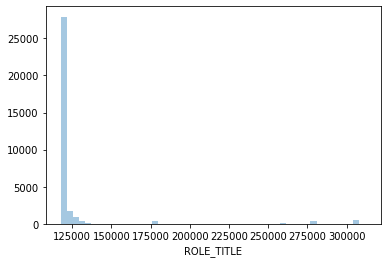

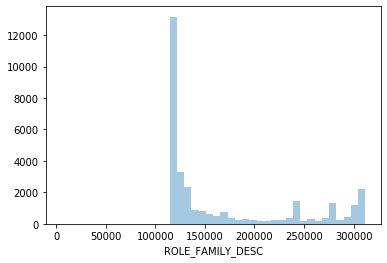

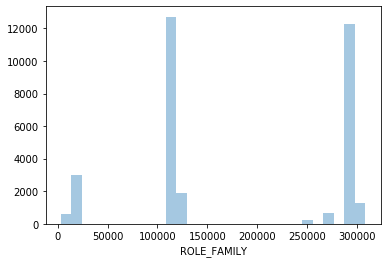

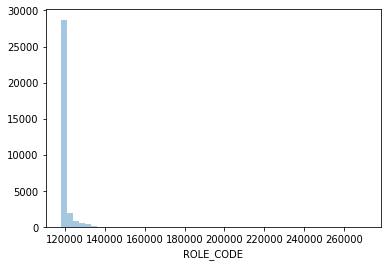

In [44]:
for i in train.var().index:
    sns.distplot(train[i],kde=False)
    plt.show()

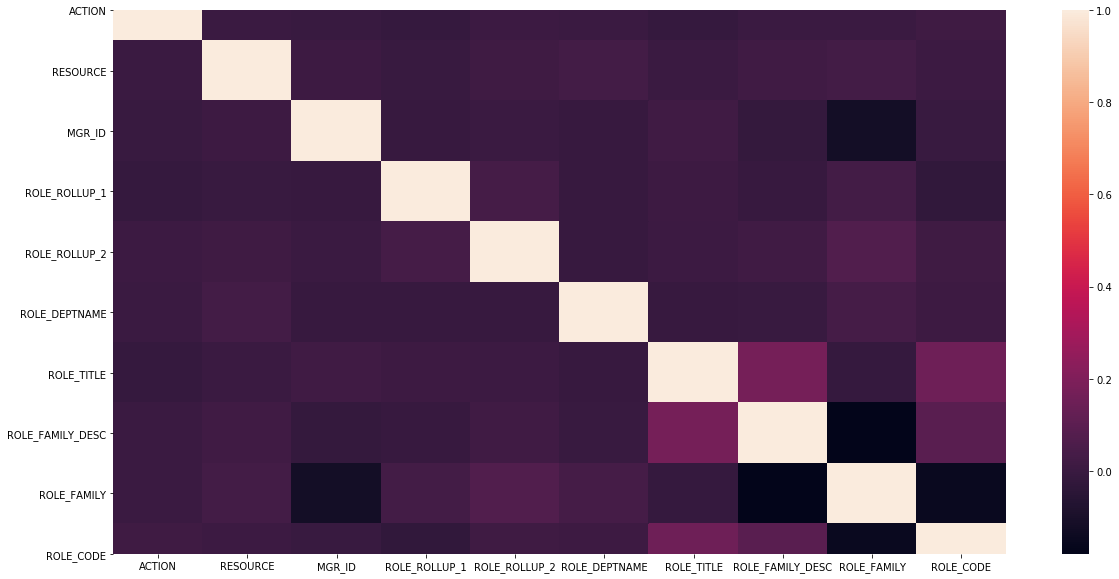

In [45]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr())

In [46]:
y_train = train['ACTION']
x_train = train[train.columns.difference(['ACTION'])]
x_test = test


# Base classifiers

In [47]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_train)
accuracy_score(y_train,predictions)

0.9421099209618847

In [48]:
clf = DummyClassifier(strategy='uniform',random_state=0)
clf.fit(x_train, y_train)
clf.score(x_train,y_train)


0.4990387256248283

In [49]:
clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(x_train, y_train)
clf.score(x_train,y_train)

0.8905978211114163

#### Благодаря использованию вышеописанных классификаторов, а также просмотру описательных характеристик данных, мы видим, что выборка несбалансированна, поэтому мы можем не рассматривать некоторые методы, дающие качественную оценку только на сбалансированных данных 


## Часть 2.

##### Decision Tree Classifier

In [50]:
from sklearn.metrics import confusion_matrix
model = DecisionTreeClassifier(max_depth=8,random_state=4, criterion='gini',min_samples_leaf=2)
X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.20,random_state=43)
model.fit(X_train,Y_train)
model.predict(X_test)
model.predict(X_train)
print(confusion_matrix(Y_test,model.predict(X_test)))
print("Confusion matrix of train model")
print(confusion_matrix(Y_train,model.predict(X_train)))
print('\nGini classifier')
print('Accuracy Score of test dataset')
print(accuracy_score(Y_test,model.predict(X_test)))
print("Accuracy Score of train dataset")
print(accuracy_score(Y_train,model.predict(X_train)))

print('\nEntropy classifier')
model2 = DecisionTreeClassifier(max_depth=8,random_state=4, criterion='entropy',min_samples_leaf=2)
X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.20,random_state=43)
model2.fit(X_train,Y_train)
model2.predict(X_test)
model2.predict(X_train)
print('Accuracy Score of test dataset')
print(accuracy_score(Y_test,model2.predict(X_test)))
print("Accuracy Score of train dataset")
print(accuracy_score(Y_train,model2.predict(X_train)))

[[  28  343]
 [  16 6167]]
Confusion matrix of train model
[[  171  1355]
 [   48 24641]]

Gini classifier
Accuracy Score of test dataset
0.9452242905096124
Accuracy Score of train dataset
0.9464810223154683

Entropy classifier
Accuracy Score of test dataset
0.9441562404638388
Accuracy Score of train dataset
0.945260347129506


In [51]:
pred_proba = model2.predict_proba(X_test)

0.7367492729608575


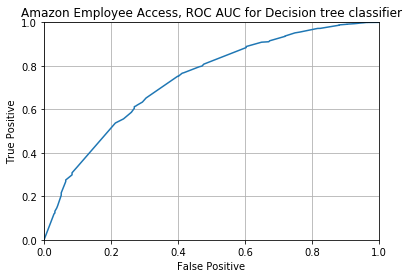

In [52]:
fpr, tpr, thresholds = roc_curve(Y_test.values,pred_proba[:,1])
print(roc_auc_score(Y_test.values,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access, ROC AUC for Decision tree classifier")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

[Text(131.91953125, 205.35999999999999, 'X[4] <= 68840.0\nentropy = 0.32\nsamples = 26215\nvalue = [1526, 24689]'),
 Text(51.7796875, 181.2, 'X[7] <= 117961.0\nentropy = 0.477\nsamples = 2905\nvalue = [298, 2607]'),
 Text(28.675, 157.04, 'X[1] <= 38164.5\nentropy = 0.261\nsamples = 838\nvalue = [37, 801]'),
 Text(15.5, 132.88, 'X[1] <= 26434.0\nentropy = 0.323\nsamples = 561\nvalue = [33, 528]'),
 Text(6.2, 108.72, 'X[6] <= 117906.0\nentropy = 0.207\nsamples = 337\nvalue = [11, 326]'),
 Text(4.65, 84.56, 'entropy = 0.0\nsamples = 116\nvalue = [0, 116]'),
 Text(7.75, 84.56, 'X[6] <= 117955.0\nentropy = 0.285\nsamples = 221\nvalue = [11, 210]'),
 Text(4.65, 60.400000000000006, 'X[1] <= 20292.5\nentropy = 0.236\nsamples = 207\nvalue = [8, 199]'),
 Text(3.1, 36.24000000000001, 'X[5] <= 126663.5\nentropy = 0.323\nsamples = 136\nvalue = [8, 128]'),
 Text(1.55, 12.079999999999984, 'entropy = 0.417\nsamples = 95\nvalue = [8, 87]'),
 Text(4.65, 12.079999999999984, 'entropy = 0.0\nsamples = 41\n

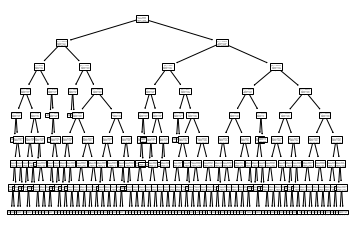

In [53]:
from sklearn import tree
tree.plot_tree(model.fit(X_train, Y_train)) # вывод дерева
tree.plot_tree(model2.fit(X_train, Y_train)) # вывод дерева

\begin{equation*}
\frac{TP+TN}{{P + N}} =\frac{TP+TN}{{TP + TN +FP +FN}}
\end{equation*}

\begin{equation*}
Precision =\frac{TP}{{TP + FP}}
\end{equation*}

\begin{equation*}
Recall =\frac{TP}{{TP + FN}}
\end{equation*}

#### Random Forest Classifier

In [54]:
model = RandomForestClassifier(n_estimators=600,
                               max_depth=15,
                               random_state=4,
                               oob_score=True,
                               n_jobs=-1)
X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.20,random_state=43)
model.fit(X_train,Y_train)
model.predict(X_test)
model.predict(X_train)
print(confusion_matrix(Y_test,model.predict(X_test)))
print('Accuracy Score of test dataset')
print(accuracy_score(Y_test,model.predict(X_test)))
print("Confusion matrix of train model")
print(confusion_matrix(Y_train,model.predict(X_train)))
print("Accuracy Score of train dataset")
print(accuracy_score(Y_train,model.predict(X_train)))

[[  74  297]
 [  33 6150]]
Accuracy Score of test dataset
0.9496490692706744
Confusion matrix of train model
[[  703   823]
 [    2 24687]]
Accuracy Score of train dataset
0.9685294678619111


0.8736416650645866


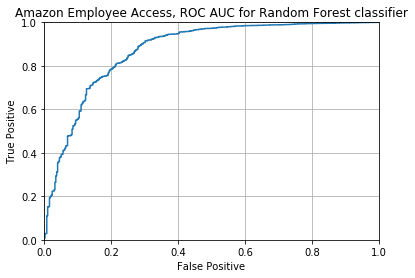

In [55]:
pred_proba = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test.values,pred_proba[:,1])
print(roc_auc_score(Y_test.values,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access, ROC AUC for Random Forest classifier")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

##### Bagging

In [56]:
b_model = BaggingClassifier()
b_model.fit(X_train,Y_train)
b_model.predict(X_test)
b_model.predict(X_train)
print(confusion_matrix(Y_test,b_model.predict(X_test)))
print('Accuracy Score of test dataset')
print(accuracy_score(Y_test,b_model.predict(X_test)))
print("Confusion matrix of train model")
print(confusion_matrix(Y_train,b_model.predict(X_train)))
print("Accuracy Score of train dataset")
print(accuracy_score(Y_train,b_model.predict(X_train)))

[[ 153  218]
 [ 121 6062]]
Accuracy Score of test dataset
0.9482758620689655
Confusion matrix of train model
[[ 1451    75]
 [   38 24651]]
Accuracy Score of train dataset
0.9956894907495708


0.8221843826194161


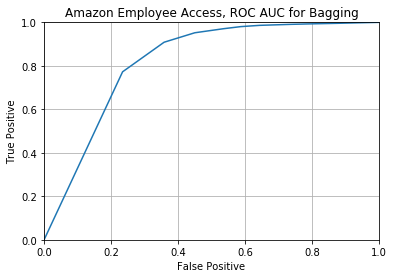

In [58]:
pred_proba = b_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test.values,pred_proba[:,1])
print(roc_auc_score(Y_test.values,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access, ROC AUC for Bagging")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

##### AdaBoost

In [59]:
# для применения критерий используем модель случайного леса, так как из построенных нами моделей она выдает наилучший результат
bdt = AdaBoostClassifier(model,
                         algorithm="SAMME",
                         n_estimators=1)

bdt.fit(X_train, Y_train)
y_pred = bdt.predict(X_test)

print("Accuracy:",accuracy_score(Y_test, y_pred))

Accuracy: 0.9496490692706744


0.8746308132070677


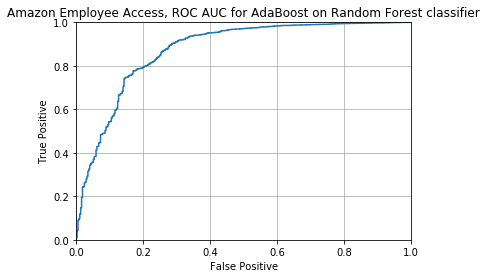

In [61]:
pred_proba = bdt.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test.values,pred_proba[:,1])
print(roc_auc_score(Y_test.values,pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access, ROC AUC for AdaBoost on Random Forest classifier")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

## Часть 3. Изменяем признаки.

In [62]:
#Убираем искомый параметр из тренировочной выборки
train.pop("ACTION")
train.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [63]:
test.pop("id")
test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,42093,50015,117961,118343,119598,118422,300136,118424,118425


##### пробуем one-hot encoding


One-hot Encoding применяется, когда один признак может принимать множество различных значений. Для удобства создается группа новых признаков, число которых равно числу уникальных значений признака. Далее на позицию, соответствующую численному значению признака мы помещаем 1, а значения остальных признаков делаем равными нулю. Таким образом работа с номинальными признаками становится понятной и логичной, чем нахождение числовых значений из строк и буквенных символов.

In [64]:
data = pd.concat([train, test],axis=0)
print("The data size is : {} ".format(data.shape))

data_dummies = pd.get_dummies(data, columns=data.columns, drop_first=True) 
print("The data_dummies size is : {} ".format(data_dummies.shape))

The data size is : (91690, 9) 
The data_dummies size is : (91690, 16952) 


In [65]:
lr_train = data_dummies.iloc[:y.shape[0]]
lr_test = data_dummies.iloc[y.shape[0]:]

print("The  new_train size is : {} ".format(lr_train.shape))
print("The  new_test size is : {} ".format(lr_test.shape))

The  new_train size is : (32769, 16952) 
The  new_test size is : (58921, 16952) 


## Logistic regression on hot encoded data

In [66]:
lr = LogisticRegression(random_state=333,C=0.99,class_weight="balanced",penalty="l1")

In [67]:
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_train, y, test_size=0.4)

H:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


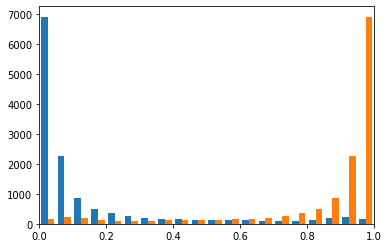

In [68]:
lr.fit(lr_X_train,lr_y_train)
lr_pred_proba = lr.predict_proba(lr_X_test)

plt.hist(lr_pred_proba,bins=20)
plt.xlim([0.0,1.0])

plt.show()

##### ROC AUC

0.845896929034913


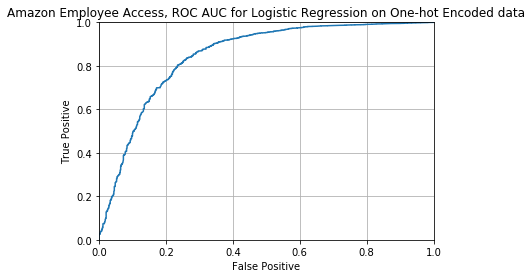

In [69]:
fpr, tpr, thresholds = roc_curve(lr_y_test.values,lr_pred_proba[:,1])
print(roc_auc_score(lr_y_test.values,lr_pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access, ROC AUC for Logistic Regression on One-hot Encoded data")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

### Random forest

In [70]:
#убираем признак ROLE_CODE в связи с тем что он дублируется
train.pop("ROLE_CODE")
test.pop("ROLE_CODE")

0        117880
1        118865
2        118175
3        120774
4        118425
          ...  
58916    118786
58917    118055
58918    118279
58919    118322
58920    119435
Name: ROLE_CODE, Length: 58921, dtype: int64

In [71]:
# Соединяем тестовую и тренировочную выборку
rf_all_data = pd.concat([train, test],axis=0)
print("The all_data size is : {} ".format(rf_all_data.shape))

The all_data size is : (91690, 8) 


In [72]:
# Находим частоту встречаемости каждого признака
def add_counts(data):
    for col in data.columns: 
        count = data[col].value_counts()
        data['count_'+col] = data[col].replace(count)
    return data

train = add_counts(rf_all_data)

In [73]:
rf_train = rf_all_data.iloc[:y.shape[0]]
rf_test = rf_all_data.iloc[y.shape[0]:]

In [74]:
rf = RandomForestClassifier(n_estimators=600,
                               max_depth=15,
                               random_state=4,
                               oob_score=True,
                               n_jobs=-1)

In [75]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_train, y, test_size=0.4)

In [76]:
rf.fit(rf_X_train,rf_y_train)
rf_pred_proba = rf.predict_proba(rf_X_test)

0.8629693601593171


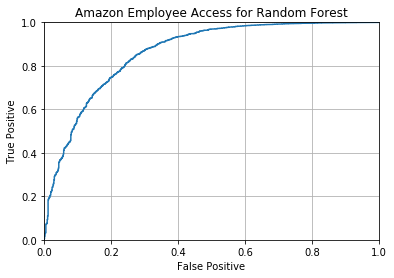

In [77]:
fpr, tpr, thresholds = roc_curve(rf_y_test.values,rf_pred_proba[:,1])
print(roc_auc_score(rf_y_test.values,rf_pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access for Random Forest")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

#### Gradient boosting

In [78]:
gbc_train = rf_train
gbc_test = rf_test

In [79]:
from sklearn.preprocessing import StandardScaler 
SS = StandardScaler(copy=False, with_mean=True, with_std=True) 
SS.fit_transform(gbc_train)
SS.fit_transform(gbc_test)

array([[ 1.16802002,  1.3113764 ,  0.09720754, ...,  0.08437938,
        -0.49106582, -0.34020656],
       [ 0.03737748, -0.63553629,  0.08628703, ..., -0.73172713,
        -0.54167847, -0.695597  ],
       [ 1.06946472, -0.69201601,  0.08628703, ..., -0.77347051,
        -0.49179302, -0.95396075],
       ...,
       [-0.00361061, -0.58609161,  0.08628703, ..., -0.68458994,
        -0.47724915,  1.48059755],
       [-1.1377232 , -0.5131778 ,  0.08628703, ...,  2.01770755,
         2.06501849,  1.48059755],
       [ 0.16588789, -0.64863799,  0.08628703, ..., -0.67239525,
        -0.40278456, -0.30585014]])

0.850016546145427


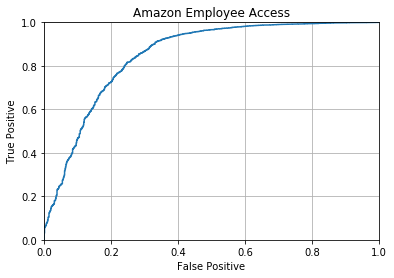

In [80]:
gbc = GradientBoostingClassifier(n_estimators=3000, min_samples_split=9)
gbc.fit(rf_X_train,rf_y_train)
gbc_pred_proba = gbc.predict_proba(rf_X_test)
fpr, tpr, thresholds = roc_curve(rf_y_test.values,gbc_pred_proba[:,1])
print(roc_auc_score(rf_y_test.values,gbc_pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

In [82]:
bdt = AdaBoostClassifier(rf,
                         algorithm="SAMME",
                         n_estimators=1)

bdt.fit(rf_X_train, rf_y_train)
y_pred = bdt.predict(rf_X_test)

print("Accuracy:",accuracy_score(rf_y_test, y_pred))

Accuracy: 0.9504119621605127


## Выводы

| Метод | Оценка |
| --- | --- |
| most frequent dummy classifier | 0.9421099209618847 |
| uniform dummy classifier | 0.4990387256248283 |
| stratified dummy classifier | 0.8905978211114163 |
| Decision Tree Classifier | 0.7367492729608575 |
| Random Forest | 0.8736416650645866 |
| Bagging | 0.8265505409363035 |
| AdaBoost on Random Forest | 0.8746308132070677 |
| One-hot Encoded Logistic Regression | 0.845896929034913 |
| One-hot encoded Random Forest | 0.8629693601593171 |
| Gradient Boosting on standartized data | 0.850016546145427 |
| AdaBoost on Random Forest and encoded data | 0.9504119621605127 |

## Выводы
Можно заметить, что на выборках, в которых признаки были обработаны методом one-hot encoding, оценки получены примерно такие же, как при необработанных данных. Лучшая оценка при использовании метода AdaBoost, который улучшил примененный алгоритм случайных деревьев - ~95% верных ответов, 87% без предобработки данных. 
После кодирования категориальных признаков, мы добились лучшей оценки в 86% применив модель случайных деревьев. Таким образом, мы видим, что при решении задачи классификации этот алгоритм подходит лучше всего из всех моделей нами рассмотренных, однако он является сложным в понимании и ручной имплементации.
Таким образом, изучив и применив различные методы тренировки модели, мы добились того, что наша лучшая модель дает ответ с ошибкой меньше, чем 5%, что является очень высоким показателем. С созданием уникальных признаков для всех уникальных значений, мы получаем модель, которая с вероятностью ~0,85 даст правильный ответ, что также является достаточно хорошим показателем.